In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setting logging to print only error messages from sklearn
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

# Import warnings module
import warnings
warnings.filterwarnings("ignore") # Ignore warnings

# Data Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, precision_recall_curve, auc

# Timer
import time
from timeit import default_timer as timer
from datetime import timedelta
from tqdm import tqdm

# 1. Load the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = '/content/drive/MyDrive/Business Analytics/Teaching materials/MIS 451/Q251/Week 4 - Classification/Lecture Notes/Credit risk.xlsx'

In [4]:
df = pd.read_excel(file_path)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Current Account  425 non-null    int64 
 1   Savings Account  425 non-null    int64 
 2   Months Customer  425 non-null    int64 
 3   Months Employed  425 non-null    int64 
 4   Age              425 non-null    int64 
 5   Housing          425 non-null    object
 6   Job              425 non-null    object
 7   Credit Risk      425 non-null    object
dtypes: int64(5), object(3)
memory usage: 26.7+ KB


In [6]:
df.head()

,Current Account,Savings Account,Months Customer,Months Employed,Age,Housing,Job,Credit Risk
0,0,739,13,12,23,Own,Unskilled,Low
1,0,1230,25,0,32,Own,Skilled,High
2,0,389,19,119,38,Own,Management,High
3,638,347,13,14,36,Own,Unskilled,High
4,963,4754,40,45,31,Rent,Skilled,Low


In [7]:
df.duplicated().sum()

np.int64(0)

# 2. Data Partitioning

In [8]:
# Train-test split
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.1, stratify=df['Credit Risk'], random_state=7)

In [9]:
# Reset index for both trainset and testset
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [10]:
train.shape, test.shape

((382, 8), (43, 8))

# 3. Exploratory Data Analysis

## 3.1. Univariate Analysis

In [11]:
train['Housing'].value_counts()

,count
Housing,
Own,260
Rent,74
Other,48


In [12]:
train['Job'].value_counts()

,count
Job,
Skilled,245
Unskilled,82
Management,45
Unemployed,10


In [13]:
train['Credit Risk'].value_counts()

,count
Credit Risk,
Low,192
High,190


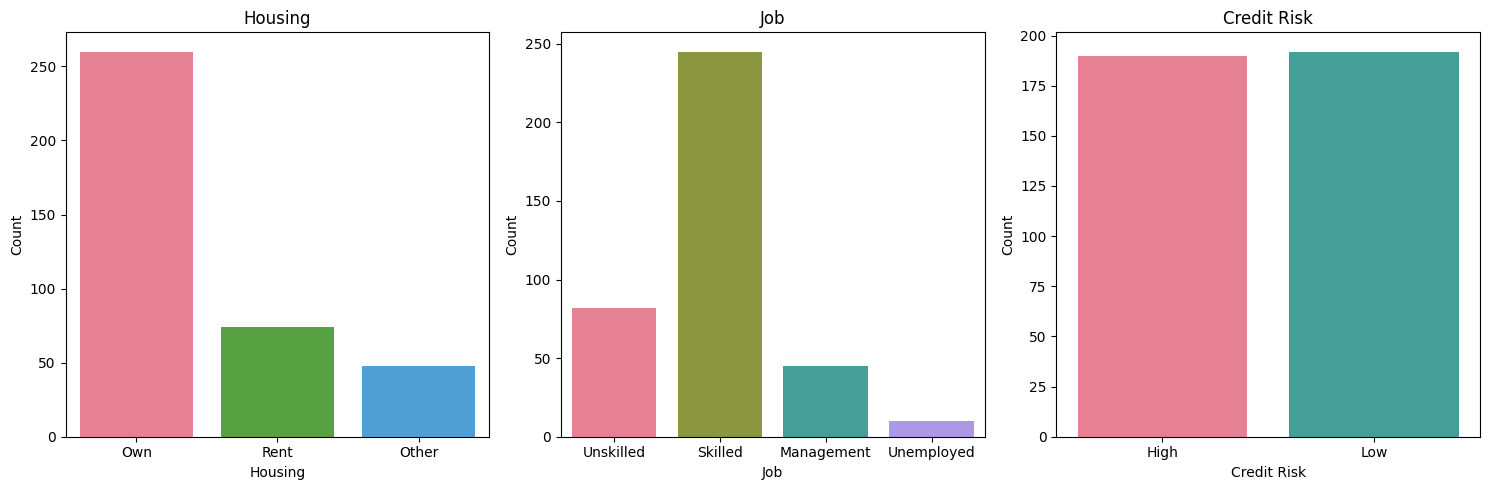

In [14]:
# Set up the matplotlib figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Columns to plot
categorical_columns = ['Housing', 'Job', 'Credit Risk']

# Loop over the columns and create bar plots for each one
for i, col in enumerate(categorical_columns):
    sns.countplot(data=train, x=col, palette='husl', ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel('Count')

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

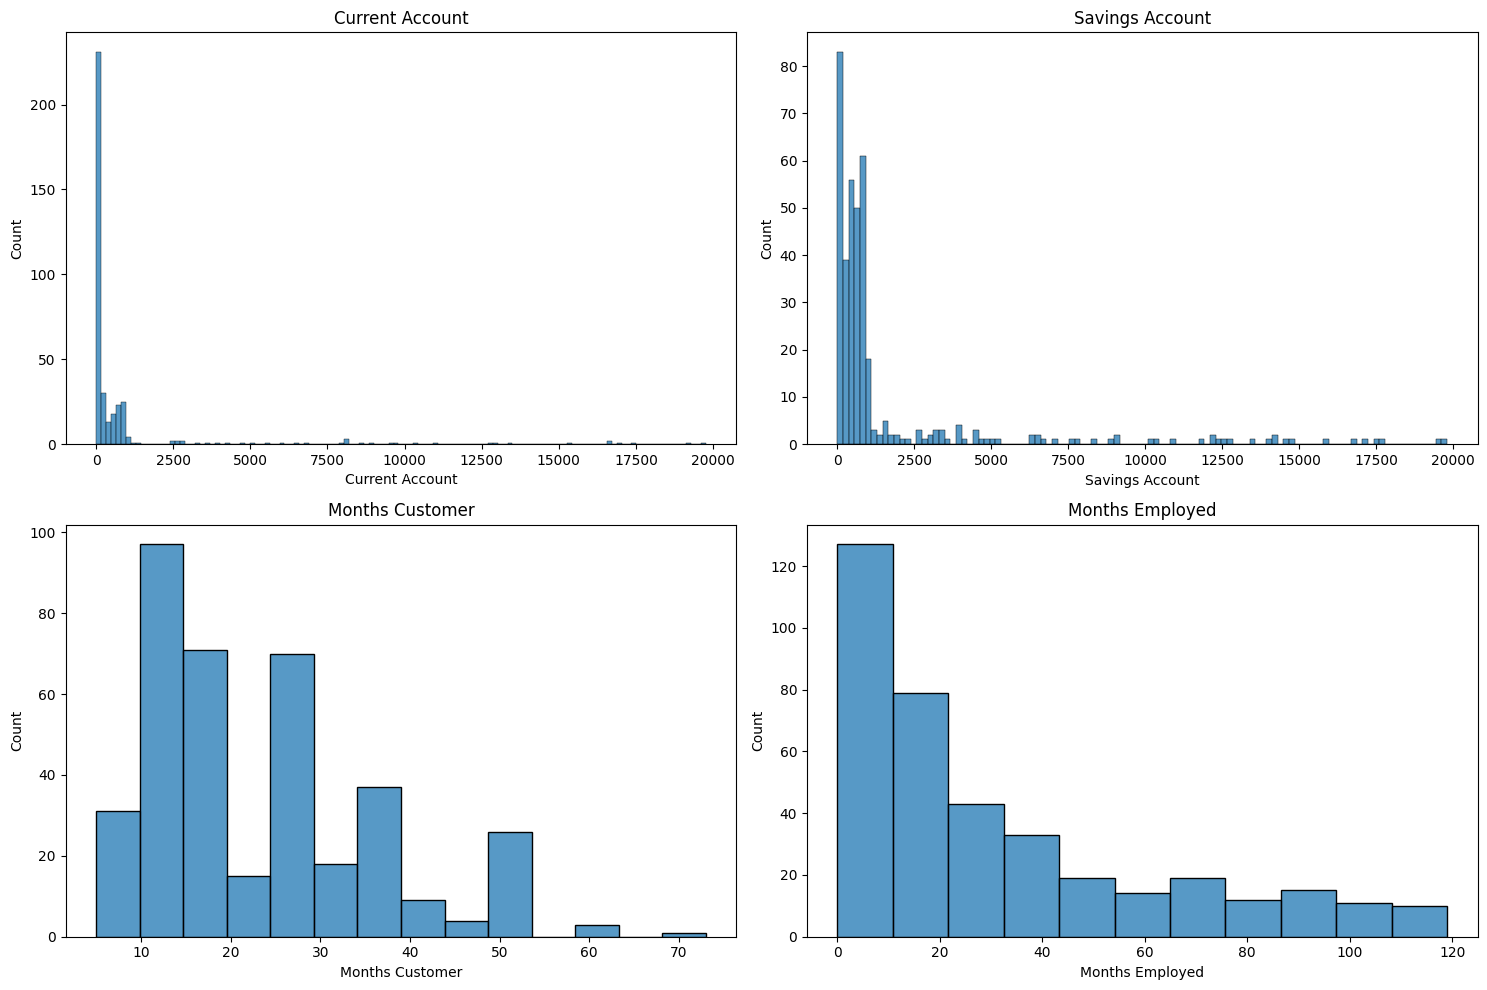

In [15]:
# Set up the matplotlib figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Columns to plot
num_col = ['Current Account', 'Savings Account', 'Months Customer', 'Months Employed']

# Loop over the columns and create bar plots for each one
for i, col in enumerate(num_col):
    row, col_idx = divmod(i, 2)  # Calculate the row and column index
    sns.histplot(data=train, x=col, palette='husl', ax=axes[row, col_idx])
    axes[row, col_idx].set_title(col)
    axes[row, col_idx].set_ylabel('Count')

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

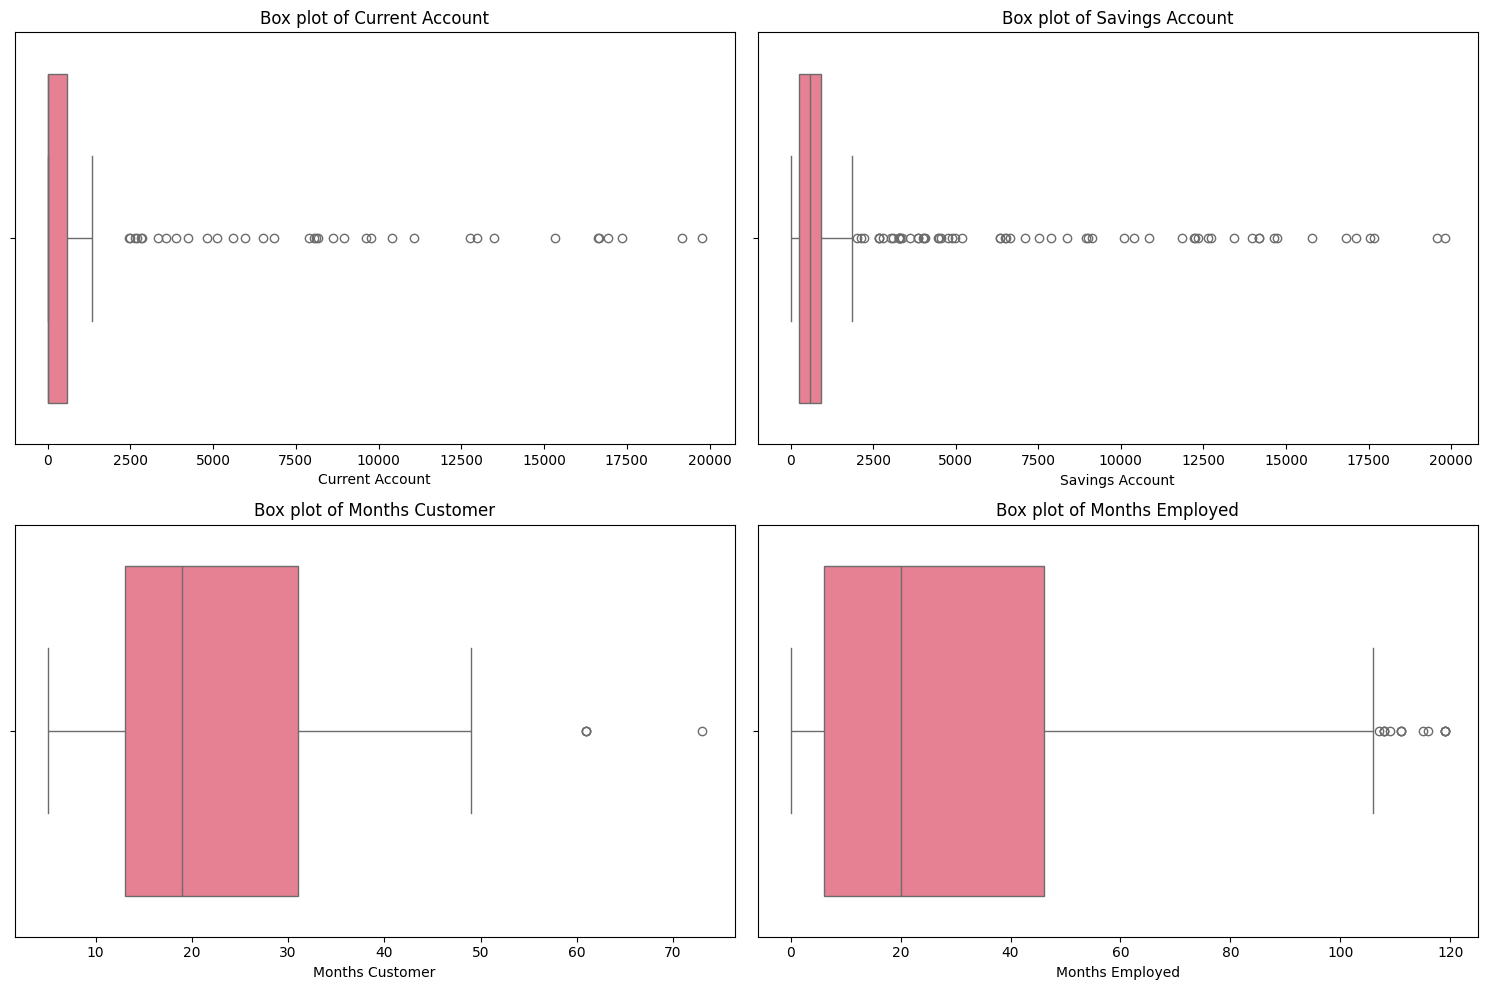

In [16]:
# Set up the matplotlib figure with 4 subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Columns to plot
num_col = ['Current Account', 'Savings Account', 'Months Customer', 'Months Employed']

# Loop over the columns and create box plots for each one
for i, col in enumerate(num_col):
    row, col_idx = divmod(i, 2)
    sns.boxplot(data=train, x=col, palette='husl', ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Box plot of {col}')
    axes[row, col_idx].set_xlabel(col)

# Adjust the layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

## 2. Bivariate Analysis

<Axes: xlabel='Job', ylabel='count'>

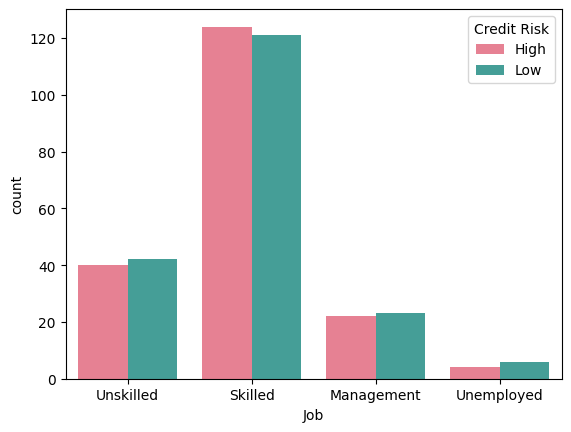

In [17]:
sns.countplot(train, x="Job", hue="Credit Risk", palette='husl')

<Axes: xlabel='Housing', ylabel='count'>

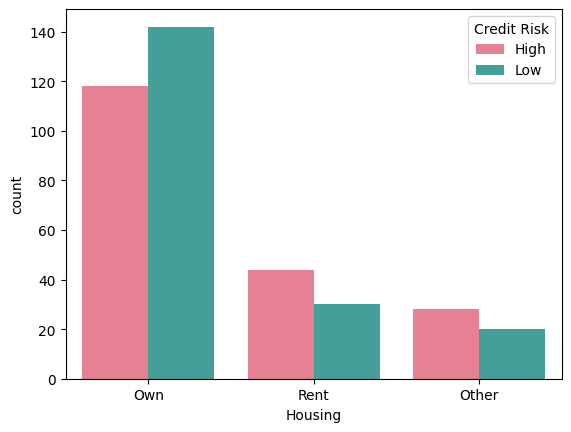

In [18]:
sns.countplot(train, x="Housing", hue="Credit Risk", palette='husl')

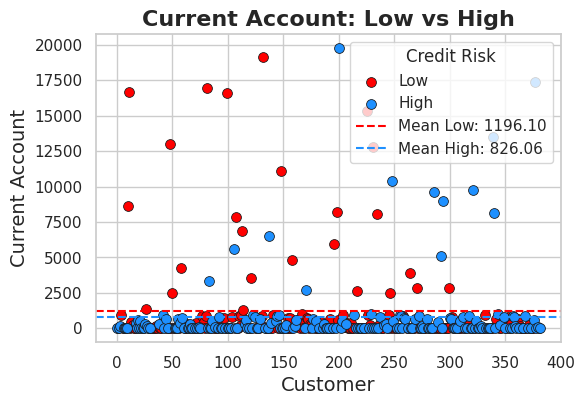

In [19]:
# Set the Seaborn style
sns.set(style="whitegrid")

# Separate the data
low = train[train['Credit Risk'] == "Low"]
high = train[train['Credit Risk'] == "High"]

# Calculate mean amounts
mean_low = low["Current Account"].mean()
mean_high = high["Current Account"].mean()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the data
sns.scatterplot(x=low.index, y=low["Current Account"], color="red",
                s=50, edgecolor="k", label="Low", ax=ax)
sns.scatterplot(x=high.index, y=high["Current Account"], color="DodgerBlue",
                s=50, edgecolor="k", label="High", ax=ax)

# Add dashed lines for mean amounts
ax.axhline(y=mean_low, color="red", linestyle="--", label=f"Mean Low: {mean_low:.2f}")
ax.axhline(y=mean_high, color="DodgerBlue", linestyle="--", label=f"Mean High: {mean_high:.2f}")

# Add labels and title
ax.set_xlabel("Customer", fontsize=14)
ax.set_ylabel("Current Account", fontsize=14)
ax.set_title("Current Account: Low vs High", fontsize=16, fontweight='bold')

# Add legend
ax.legend(title="Credit Risk")

# Display the plot
plt.show()

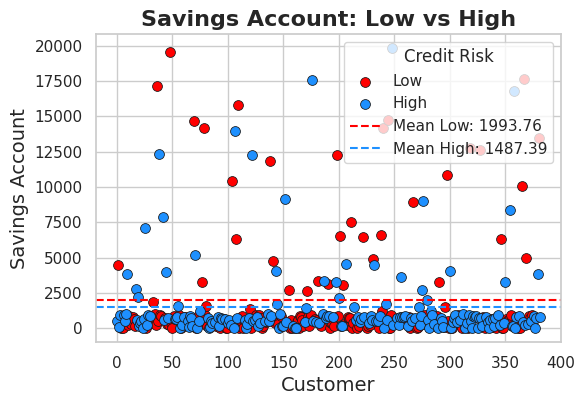

In [20]:
# Set the Seaborn style
sns.set(style="whitegrid")

# Separate the data
low = train[train['Credit Risk'] == "Low"]
high = train[train['Credit Risk'] == "High"]

# Calculate mean amounts
mean_low = low["Savings Account"].mean()
mean_high = high["Savings Account"].mean()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the data
sns.scatterplot(x=low.index, y=low["Savings Account"], color="red",
                s=50, edgecolor="k", label="Low", ax=ax)
sns.scatterplot(x=high.index, y=high["Savings Account"], color="DodgerBlue",
                s=50, edgecolor="k", label="High", ax=ax)

# Add dashed lines for mean amounts
ax.axhline(y=mean_low, color="red", linestyle="--", label=f"Mean Low: {mean_low:.2f}")
ax.axhline(y=mean_high, color="DodgerBlue", linestyle="--", label=f"Mean High: {mean_high:.2f}")

# Add labels and title
ax.set_xlabel("Customer", fontsize=14)
ax.set_ylabel("Savings Account", fontsize=14)
ax.set_title("Savings Account: Low vs High", fontsize=16, fontweight='bold')

# Add legend
ax.legend(title="Credit Risk")

# Display the plot
plt.show()

# 3. Outlier Detection

In [21]:
def remove_outliers(df, numeric_columns, threshold=1.5):
    df_no_outliers = df.copy()

    for column in numeric_columns:
        # Calculate IQR
        Q1 = df_no_outliers[column].quantile(0.25)
        Q3 = df_no_outliers[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define upper and lower bounds
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Remove outliers
        df_no_outliers = df_no_outliers[(df_no_outliers[column] >= lower_bound) & (df_no_outliers[column] <= upper_bound)]

    return df_no_outliers

In [22]:
train = remove_outliers(train, num_col)

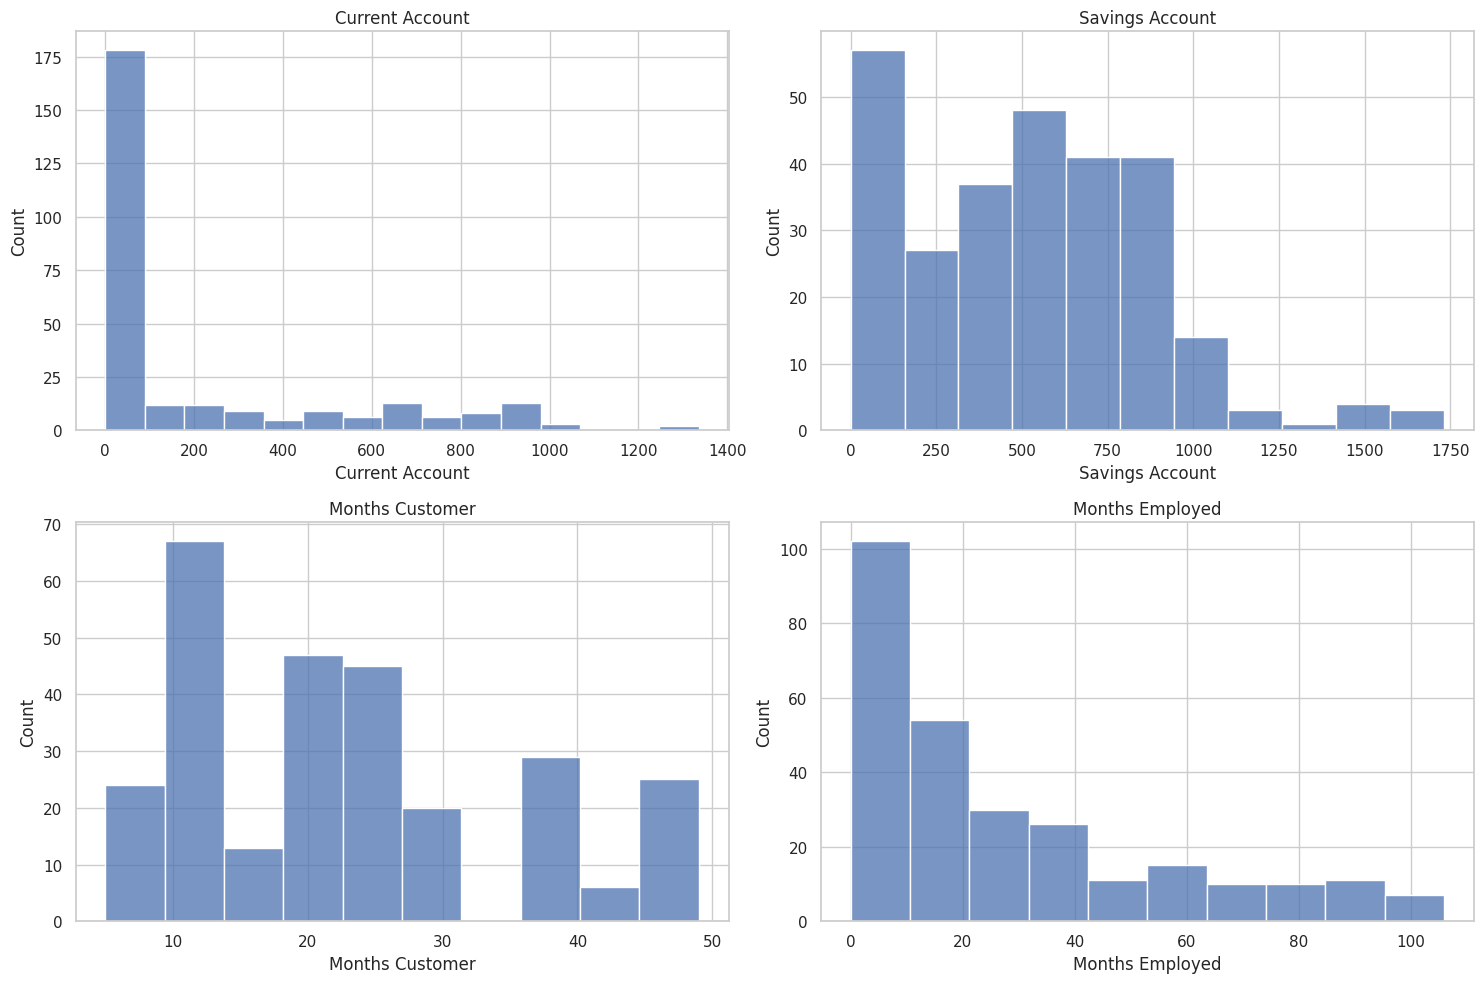

In [23]:
# Set up the matplotlib figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Columns to plot
num_col = ['Current Account', 'Savings Account', 'Months Customer', 'Months Employed']

# Loop over the columns and create bar plots for each one
for i, col in enumerate(num_col):
    row, col_idx = divmod(i, 2)  # Calculate the row and column index
    sns.histplot(data=train, x=col, palette='husl', ax=axes[row, col_idx])
    axes[row, col_idx].set_title(col)
    axes[row, col_idx].set_ylabel('Count')

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

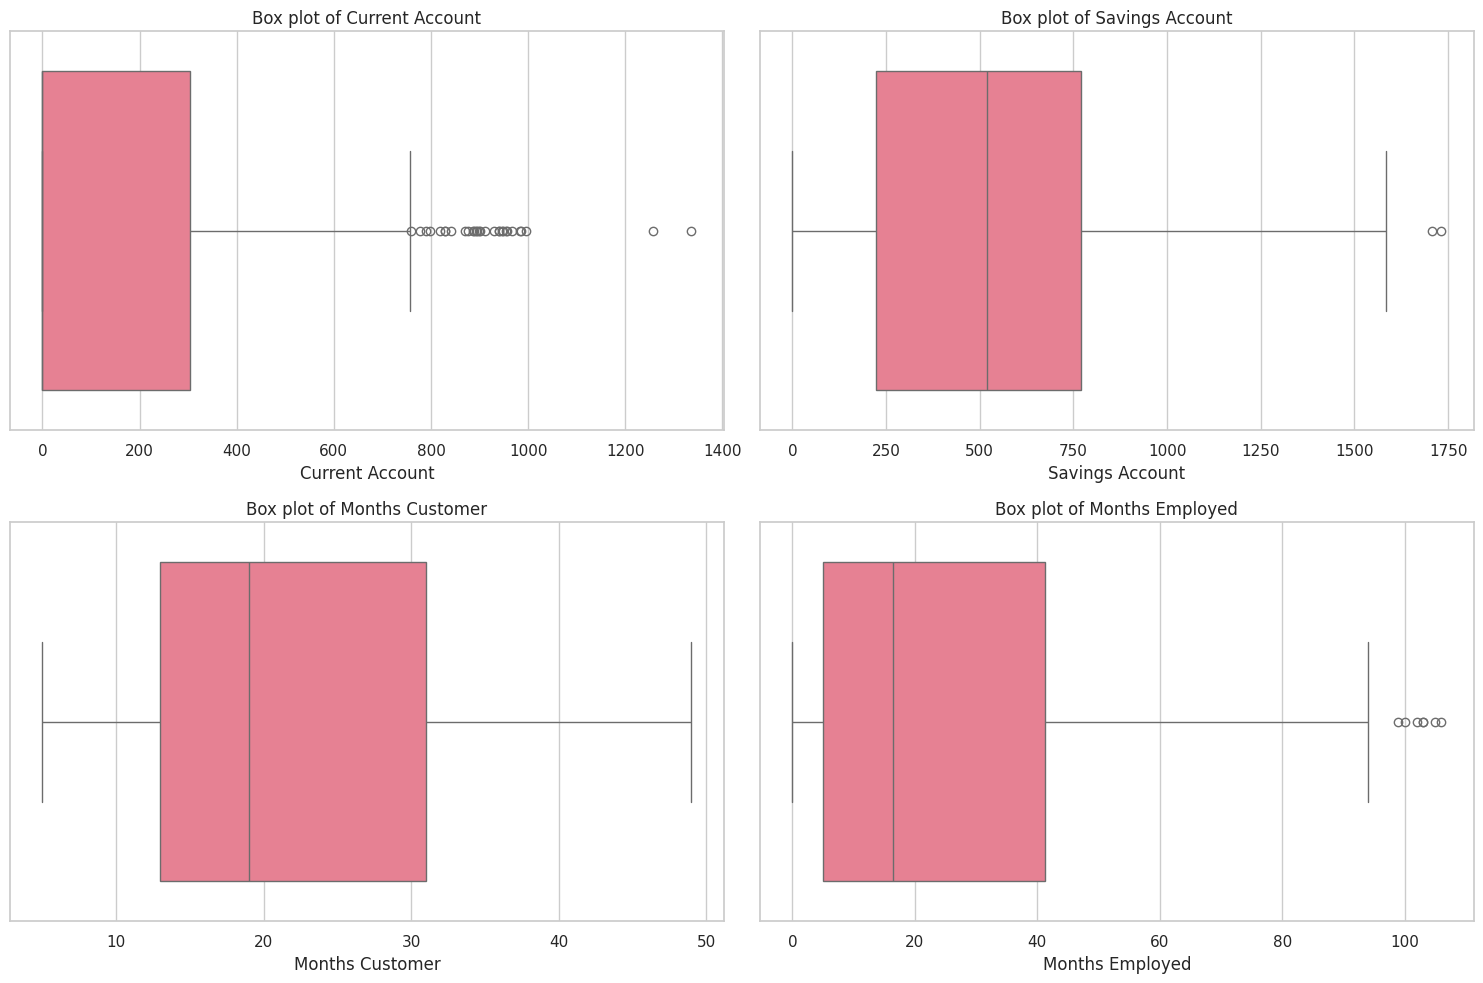

In [24]:
# Set up the matplotlib figure with 4 subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2 rows and 2 columns for 4 box plots

# Columns to plot
num_col = ['Current Account', 'Savings Account', 'Months Customer', 'Months Employed']

# Loop over the columns and create box plots for each one
for i, col in enumerate(num_col):
    row, col_idx = divmod(i, 2)  # Calculate the row and column index
    sns.boxplot(data=train, x=col, palette='husl', ax=axes[row, col_idx])  # Create a box plot for each column
    axes[row, col_idx].set_title(f'Box plot of {col}')
    axes[row, col_idx].set_xlabel(col)

# Adjust the layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

# 4. Data Transformation

In [25]:
train['Credit Risk'] = train['Credit Risk'].replace({'Low': 0, 'High': 1})

In [26]:
test['Credit Risk'] = test['Credit Risk'].replace({'Low': 0, 'High': 1})

In [27]:
train.head()

,Current Account,Savings Account,Months Customer,Months Employed,Age,Housing,Job,Credit Risk
0,0,508,13,3,32,Own,Unskilled,1
2,0,108,25,52,46,Own,Unskilled,1
3,166,922,13,2,24,Rent,Skilled,1
4,949,0,49,36,23,Own,Skilled,0
5,0,0,11,4,30,Rent,Skilled,0


In [28]:
test.head()

,Current Account,Savings Account,Months Customer,Months Employed,Age,Housing,Job,Credit Risk
0,0,987,37,101,30,Own,Skilled,1
1,0,11587,22,46,30,Own,Management,0
2,317,10980,13,17,65,Own,Unskilled,1
3,0,5564,25,93,33,Own,Skilled,0
4,265,947,25,5,21,Own,Skilled,1


## 4.1. Category Encoding

In [29]:
one_hot_encoder = OneHotEncoder(drop="first", sparse_output=False)

In [30]:
# categorical columns to transform
cat_cols = ['Housing']

# fit an encoder and transform the trainset
cat_vals = train[cat_cols]
cat_vals

,Housing
0,Own
2,Own
3,Rent
4,Own
5,Rent
...,...
374,Own
375,Own
376,Own
378,Other


In [31]:
# Fit and transform the categorical values
transformed = one_hot_encoder.fit_transform(cat_vals)
transformed

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 0.],
       [1., 0.],
       [1., 0.],
       [0., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 0.],
       [1., 0.],
       [0., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 0.],
       [1., 0.

In [32]:
# the names of the new columns
new_col_names = one_hot_encoder.get_feature_names_out(cat_cols)
new_col_names

array(['Housing_Own', 'Housing_Rent'], dtype=object)

In [33]:
# put the transformed data as columns in the trainset dataframe
for i, new_col_name in enumerate(new_col_names):
    train[new_col_name] = transformed[:,i]

# check if the dummies are produced correctly in the trainset
train.head()

,Current Account,Savings Account,Months Customer,Months Employed,Age,Housing,Job,Credit Risk,Housing_Own,Housing_Rent
0,0,508,13,3,32,Own,Unskilled,1,1.0,0.0
2,0,108,25,52,46,Own,Unskilled,1,1.0,0.0
3,166,922,13,2,24,Rent,Skilled,1,0.0,1.0
4,949,0,49,36,23,Own,Skilled,0,1.0,0.0
5,0,0,11,4,30,Rent,Skilled,0,0.0,1.0


In [34]:
# delete the original categorical columns
train = train.drop(cat_cols, axis=1)

In [35]:
train.head()

,Current Account,Savings Account,Months Customer,Months Employed,Age,Job,Credit Risk,Housing_Own,Housing_Rent
0,0,508,13,3,32,Unskilled,1,1.0,0.0
2,0,108,25,52,46,Unskilled,1,1.0,0.0
3,166,922,13,2,24,Skilled,1,0.0,1.0
4,949,0,49,36,23,Skilled,0,1.0,0.0
5,0,0,11,4,30,Skilled,0,0.0,1.0


In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276 entries, 0 to 381
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Current Account  276 non-null    int64  
 1   Savings Account  276 non-null    int64  
 2   Months Customer  276 non-null    int64  
 3   Months Employed  276 non-null    int64  
 4   Age              276 non-null    int64  
 5   Job              276 non-null    object 
 6   Credit Risk      276 non-null    int64  
 7   Housing_Own      276 non-null    float64
 8   Housing_Rent     276 non-null    float64
dtypes: float64(2), int64(6), object(1)
memory usage: 21.6+ KB


In [37]:
# transform the testing set using the encoder fitted on test
cat_vals = test[cat_cols]
transformed = one_hot_encoder.transform(cat_vals)

# put the transformed data as columns in the testset dataframe
for i, new_col_name in enumerate(new_col_names):
    test[new_col_name] = transformed[:,i]

# check if the dummies are produced correctly in the testset
test.head()

,Current Account,Savings Account,Months Customer,Months Employed,Age,Housing,Job,Credit Risk,Housing_Own,Housing_Rent
0,0,987,37,101,30,Own,Skilled,1,1.0,0.0
1,0,11587,22,46,30,Own,Management,0,1.0,0.0
2,317,10980,13,17,65,Own,Unskilled,1,1.0,0.0
3,0,5564,25,93,33,Own,Skilled,0,1.0,0.0
4,265,947,25,5,21,Own,Skilled,1,1.0,0.0


In [38]:
# delete the original categorical columns
test = test.drop(cat_cols, axis=1)

In [39]:
test.shape

(43, 9)

In [40]:
# Double check the results
test.head()

,Current Account,Savings Account,Months Customer,Months Employed,Age,Job,Credit Risk,Housing_Own,Housing_Rent
0,0,987,37,101,30,Skilled,1,1.0,0.0
1,0,11587,22,46,30,Management,0,1.0,0.0
2,317,10980,13,17,65,Unskilled,1,1.0,0.0
3,0,5564,25,93,33,Skilled,0,1.0,0.0
4,265,947,25,5,21,Skilled,1,1.0,0.0


In [41]:
job_mapping = {
    'Unemployed': 0,
    'Unskilled': 1,
    'Skilled': 2,
    'Management': 3
}

train['Job'] = train['Job'].replace(job_mapping)
test['Job'] = test['Job'].replace(job_mapping)

In [42]:
train.head()

,Current Account,Savings Account,Months Customer,Months Employed,Age,Job,Credit Risk,Housing_Own,Housing_Rent
0,0,508,13,3,32,1,1,1.0,0.0
2,0,108,25,52,46,1,1,1.0,0.0
3,166,922,13,2,24,2,1,0.0,1.0
4,949,0,49,36,23,2,0,1.0,0.0
5,0,0,11,4,30,2,0,0.0,1.0


In [43]:
# separate the target and predictors
ytrain = train["Credit Risk"].copy()
Xtrain = train.drop("Credit Risk", axis=1)
ytest = test["Credit Risk"].copy()
Xtest = test.drop("Credit Risk", axis=1)

In [44]:
Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((276, 8), (276,), (43, 8), (43,))

In [45]:
Xtrain.head()

,Current Account,Savings Account,Months Customer,Months Employed,Age,Job,Housing_Own,Housing_Rent
0,0,508,13,3,32,1,1.0,0.0
2,0,108,25,52,46,1,1.0,0.0
3,166,922,13,2,24,2,0.0,1.0
4,949,0,49,36,23,2,1.0,0.0
5,0,0,11,4,30,2,0.0,1.0


# Scaling

In [46]:
numeric_features = ["Current Account", "Savings Account",
                    "Months Customer", "Months Employed", "Age"]


X_train_scaled = Xtrain.copy()
X_test_scaled = Xtest.copy()

# Initialize scaler
scaler = StandardScaler()

# Fit
X_train_scaled[numeric_features] = scaler.fit_transform(Xtrain[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(Xtest[numeric_features])


In [47]:
X_train_scaled.head()

,Current Account,Savings Account,Months Customer,Months Employed,Age,Job,Housing_Own,Housing_Rent
0,-0.617775,-0.029343,-0.833688,-0.871294,-0.202025,1,1.0,0.0
2,-0.617775,-1.139131,0.150688,0.882707,1.114374,1,1.0,0.0
3,-0.100316,1.119288,-0.833688,-0.907090,-0.954253,2,0.0,1.0
4,2.340471,-1.438774,2.119440,0.309972,-1.048282,2,1.0,0.0
5,-0.617775,-1.438774,-0.997750,-0.835498,-0.390082,2,0.0,1.0


In [48]:
X_test_scaled.head()

,Current Account,Savings Account,Months Customer,Months Employed,Age,Job,Housing_Own,Housing_Rent
0,-0.617775,1.299628,1.135064,2.636708,-0.390082,2,1.0,0.0
1,-0.617775,30.709009,-0.095406,0.667931,-0.390082,3,1.0,0.0
2,0.370385,29.024906,-0.833688,-0.370151,2.900916,1,1.0,0.0
3,-0.617775,13.998377,0.150688,2.350340,-0.107997,2,1.0,0.0
4,0.208289,1.188649,0.150688,-0.799702,-1.236339,2,1.0,0.0


In [49]:
Xtrain.head()

,Current Account,Savings Account,Months Customer,Months Employed,Age,Job,Housing_Own,Housing_Rent
0,0,508,13,3,32,1,1.0,0.0
2,0,108,25,52,46,1,1.0,0.0
3,166,922,13,2,24,2,0.0,1.0
4,949,0,49,36,23,2,1.0,0.0
5,0,0,11,4,30,2,0.0,1.0


In [50]:
Xtest.head()

,Current Account,Savings Account,Months Customer,Months Employed,Age,Job,Housing_Own,Housing_Rent
0,0,987,37,101,30,2,1.0,0.0
1,0,11587,22,46,30,3,1.0,0.0
2,317,10980,13,17,65,1,1.0,0.0
3,0,5564,25,93,33,2,1.0,0.0
4,265,947,25,5,21,2,1.0,0.0


# 5. Model Development

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, accuracy_score
from sklearn.model_selection import cross_val_score

In [52]:
# Create a function to evaluate the model
# model: trained model
# ytest, Xtest: the data to test
def evaluate_model(model, ytest, Xtest):
    yhat = model.predict(Xtest)
    print(classification_report(ytest, yhat, zero_division=0))

# Displays cross-validation results with a given grid_search object
def print_cv_results(grid_search, col_width=100, max_rows=10):
    results = pd.DataFrame(grid_search.cv_results_
                             )[['params', 'mean_train_score', 'mean_test_score']]
    # Calculating the difference between mean_train_score and mean_test_score as a percentage
    results["diff, %"] = 100*(results["mean_train_score"]-results["mean_test_score"]
                                                         )/results["mean_train_score"]
    # Setting display options for pandas DataFrame
    pd.set_option('display.max_colwidth', col_width)
    pd.set_option('display.min_rows', max_rows)
    pd.set_option('display.max_rows', max_rows)
    display(results.sort_values('mean_test_score', ascending=False))

# KNN

In [53]:
from sklearn.neighbors import KNeighborsClassifier

In [54]:
knn = KNeighborsClassifier(n_neighbors=5)
knn_fscore = cross_val_score(knn, X_train_scaled, ytrain, scoring='f1_macro', cv=10)

In [55]:
knn_fscore

array([0.65714286, 0.70053476, 0.5625    , 0.64102564, 0.67816092,
       0.5       , 0.69318182, 0.51586207, 0.625     , 0.51586207])

In [56]:
knn_fscore.mean()

np.float64(0.6089270133179869)

# SVM

In [57]:
from sklearn.svm import SVC

In [58]:
svc = SVC()
svc_fscore = cross_val_score(svc, X_train_scaled, ytrain, scoring='f1_macro', cv=10)

In [59]:
svc_fscore

array([0.71282051, 0.56923077, 0.53512133, 0.60258065, 0.64102564,
       0.74968072, 0.7       , 0.59034483, 0.48076923, 0.44137931])

In [60]:
svc_fscore.mean()

np.float64(0.6022952980361211)

# Logistic Regression

In [61]:
from sklearn.linear_model import LogisticRegression

In [62]:
lr = LogisticRegression()
lr_fscore = cross_val_score(lr, Xtrain, ytrain, scoring='f1_macro', cv=10)

In [63]:
lr_fscore

array([0.44664032, 0.56923077, 0.56923077, 0.56923077, 0.56923077,
       0.78571429, 0.7032967 , 0.49350649, 0.55494505, 0.59259259])

In [64]:
lr_fscore.mean()

np.float64(0.585361852318374)

# Decision Tree

In [65]:
from sklearn.tree import DecisionTreeClassifier

In [66]:
dt = DecisionTreeClassifier()
dt_fscore = cross_val_score(dt, Xtrain, ytrain, scoring='f1_macro', cv=10)

In [67]:
dt_fscore

array([0.5625    , 0.78461538, 0.53512133, 0.53512133, 0.50877193,
       0.46360153, 0.40659341, 0.475     , 0.40659341, 0.44137931])

In [68]:
dt_fscore.mean()

np.float64(0.511929762698819)

# Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier

In [70]:
rf = RandomForestClassifier()
rf_fscore = cross_val_score(rf, Xtrain, ytrain, scoring='f1_macro', cv=10)

In [71]:
rf_fscore

array([0.66798419, 0.70833333, 0.53512133, 0.60664112, 0.53333333,
       0.64102564, 0.65918654, 0.58345021, 0.62912088, 0.49350649])

In [72]:
rf_fscore.mean()

np.float64(0.6057703068293339)

# Model Comparison

In [73]:
print(f"KNN: {knn_fscore.mean()}")
print(f"SVM: {svc_fscore.mean()}")
print(f"LR: {lr_fscore.mean()}")
print(f"DT: {dt_fscore.mean()}")
print(f"RF: {rf_fscore.mean()}")

KNN: 0.6089270133179869
SVM: 0.6022952980361211
LR: 0.585361852318374
DT: 0.511929762698819
RF: 0.6057703068293339


KNN achieved the best performance on the training set. As a result, this is the final model.

# Final Model

In [74]:
knn = KNeighborsClassifier()
knn.fit(Xtrain, ytrain)

KNeighborsClassifier()

In [75]:
yhat = knn.predict(Xtest)

In [76]:
evaluate_model(knn, ytest, Xtest)

              precision    recall  f1-score   support

           0       0.50      0.41      0.45        22
           1       0.48      0.57      0.52        21

    accuracy                           0.49        43
   macro avg       0.49      0.49      0.49        43
weighted avg       0.49      0.49      0.49        43



# **Citing this Notebook**
If you use this notebook in your work, please cite it as follows:

Linh, H. (2025). Machine Learning for Business. Lecture examples and exercises. (Version 1.0.0). URL: https://github.com/MsLinhEIU/MIS-451---Machine-Learning-for-Business-Analytics/tree/main